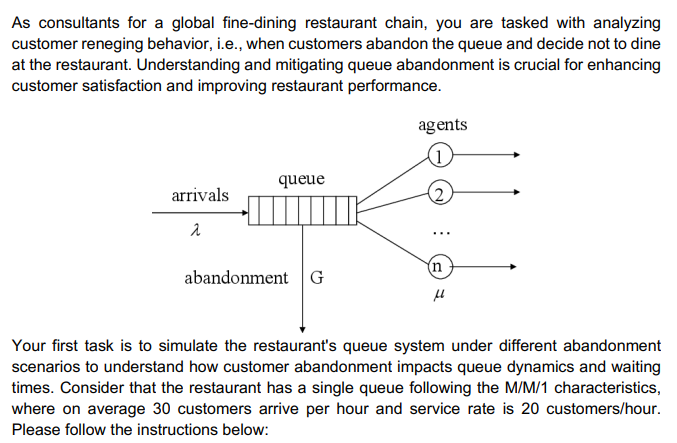

# Parameter

In [111]:
import simpy
import random
import statistics as stats

RANDOM_SEED = 660265

LAMBDA = 30      # arrival rate (customers per hour)
MU = 20          # service rate (customers per hour)
MAX_CUSTOMERS = 10000

ABANDON_RATE_MIN = 6   # e.g. mean patience = 1/6 hour = 10 minutes -> The lowerbound of waiting for a fancy restaurant
ABANDON_RATE_MAX = 30 # e.g. mean patience = 1/20 hour = 3 minutes -> The upper bound time waiting for a fancy restaurant

# A. Random Abandonment Rate

In [112]:
# First we need to define a single customer: when they arrive, waits, abandons, or gets served.
def customer(env, name, server, mu, theta, stats_dict):
    arrival_time = env.now

    # theta = rate of losing patience; patience ~ Exp(theta) 
    patience_time = random.expovariate(theta) 

    with server.request() as req:
        # Either we get the server, or patience runs out
        result = yield req | env.timeout(patience_time)

        if req in result:
            # Got into service before abandoning
            wait = env.now - arrival_time
            #Stats dictionary is used to make it easier to store the data
            stats_dict["served"] += 1
            stats_dict["wait_times"].append(wait)
            
            #How long does it take for customer to be served by the server.
            service_time = random.expovariate(mu)
            yield env.timeout(service_time)

        else:
            # Timed out -> abandonment
            stats_dict["abandoned"] += 1
            stats_dict["abandon_times"].append(env.now - arrival_time)
            stats_dict["abandon_event_times"].append(env.now)

In [113]:
def arrival_process_fixed(env, lambd, server, mu, theta, stats_dict, max_customers):
    for i in range(1, max_customers + 1):
        interarrival = random.expovariate(lambd)
        yield env.timeout(interarrival)

        env.process(customer(env,
                             name=f"C{i}",
                             server=server,
                             mu=mu,
                             theta=theta,
                             stats_dict=stats_dict))

In [114]:
def queue_monitor(env, server, stats_dict, sample_interval=0.01, max_customers=None):
    while True:
        # record the current queue length
        q_len = len(server.queue)
        stats_dict["queue_length_samples"].append(q_len)
        stats_dict["queue_timestamps"].append(env.now)

        # if we’re using a fixed number of customers, stop monitoring
        if max_customers is not None:
            total_done = stats_dict["served"] + stats_dict["abandoned"]
            if total_done >= max_customers:
                break

        yield env.timeout(sample_interval)   # sample every 0.01 hours


In [115]:
def run_simulation(lambd=LAMBDA, mu=MU, max_customers=MAX_CUSTOMERS):
    random.seed(RANDOM_SEED)

    # draw a random abandonment rate theta (per hour) on that day
    theta = random.uniform(ABANDON_RATE_MIN, ABANDON_RATE_MAX)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    stats_dict = {
        "served": 0,
        "abandoned": 0,
        "wait_times": [],
        "abandon_times": [],
        "queue_length_samples": [],
        "queue_timestamps": [],
        "q_len_at_arrival": [],
        "queue_times": [],
        "abandon_event_times": []
    }

    # arrivals: fixed number of customers
    env.process(arrival_process_fixed(env, lambd, server, mu, theta, stats_dict, max_customers))

    # queue monitor: stop when we reach max_customers finished (served+abandoned)
    env.process(queue_monitor(env, server, stats_dict, sample_interval=0.01, max_customers=max_customers))

    # run until there are no more events (all customers finished)
    env.run()

    # basic performance measures
    total_customers = stats_dict["served"] + stats_dict["abandoned"]
    served = stats_dict["served"]
    abandoned = stats_dict["abandoned"]
    avg_q_len = stats.mean(stats_dict["queue_length_samples"])

    print(f"\n=== Simulation results (M/M/1 with abandonment, fixed customers) ===")
    print(f"λ (arrival rate):      {lambd:.2f} / hour")
    print(f"μ (service rate):      {mu:.2f} / hour")
    print(f"θ (abandonment rate):  {theta:.2f} / hour")
    print(f"Total arrivals target:  {max_customers}")
    print(f"Total arrivals (done):  {total_customers}")
    print(f"Served:                 {served}")
    print(f"Abandoned:              {abandoned}")
    print(f"Average queue length:   {avg_q_len:.3f}")
    if total_customers > 0:
        print(f"Abandonment fraction:   {abandoned / total_customers:.3f}")
    if stats_dict["wait_times"]:
        print(f"Avg wait (served):      {stats.mean(stats_dict['wait_times']):.3f} hours")
    if stats_dict["abandon_times"]:
        print(f"Avg wait (abandoned):   {stats.mean(stats_dict['abandon_times']):.3f} hours")

    return stats_dict


In [116]:
run_simulation();


=== Simulation results (M/M/1 with abandonment, fixed customers) ===
λ (arrival rate):      30.00 / hour
μ (service rate):      20.00 / hour
θ (abandonment rate):  16.75 / hour
Total arrivals target:  10000
Total arrivals (done):  10000
Served:                 5333
Abandoned:              4667
Average queue length:   0.842
Abandonment fraction:   0.467
Avg wait (served):      0.025 hours
Avg wait (abandoned):   0.032 hours


# B. Patience Time depends On Queue

In [117]:
#Creating the theta (impatience) grows function with queue length and not constant anymore like we set in number 1
BASE_THETA = 6     # impatience when queue length = 0 -> When queueing typical customer will wait for 10 minutes
ALPHA = 1           # how strongly impatience grows with q -> I think it is safe to assume this number as customer a fancy dining restaurant does not like to wait

def theta_of_queue(q_len):
    return min(BASE_THETA * (1 + ALPHA * q_len), 50.0)  # Capping it so it does not explode -> protect our simulation from unrealistic behavior

In [118]:
# First we need to define a single customer: when they arrive, waits, abandons, or gets served.
def customer2(env, name, server, mu, stats_dict):
    arrival_time = env.now

    # theta = rate of losing patience; patience ~ Exp(theta) 
    q_len = len(server.queue)   # queue length at arrival
    theta_i = theta_of_queue(q_len)  # abandonment rate for THIS customer
    patience_time = random.expovariate(theta_i)


    with server.request() as req:
        # Either we get the server, or patience runs out
        result = yield req | env.timeout(patience_time)

        if req in result:
            # Got into service before abandoning
            wait = env.now - arrival_time
            #Stats dictionary is used to make it easier to store the data
            stats_dict["served"] += 1
            stats_dict["wait_times"].append(wait)
            
            #How long does it take for customer to be served by the server.
            service_time = random.expovariate(mu)
            yield env.timeout(service_time)

        else:
            # Timed out -> abandonment
            stats_dict["abandoned"] += 1
            stats_dict["abandon_times"].append(env.now - arrival_time)
            stats_dict["abandon_event_times"].append(env.now)

In [119]:
def arrival_process_fixed2(env, lambd, server, mu, stats_dict, max_customers):
    for i in range(1, max_customers + 1):
        interarrival = random.expovariate(lambd)
        yield env.timeout(interarrival)

        env.process(customer2(env,
                             name=f"C{i}",
                             server=server,
                             mu=mu,
                             stats_dict=stats_dict))


In [120]:
def run_simulation2(lambd=LAMBDA, mu=MU, max_customers=MAX_CUSTOMERS):
    random.seed(RANDOM_SEED)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    stats_dict = {
        "served": 0,
        "abandoned": 0,
        "wait_times": [],
        "abandon_times": [],
        "queue_length_samples": [],
        "queue_timestamps": [],
        "q_len_at_arrival": [],
        "queue_times": [],
        "abandon_event_times": []
    }

    # arrivals: fixed number of customers
    env.process(arrival_process_fixed2(env, lambd, server, mu, stats_dict, max_customers))

    # queue monitor: stop when we reach max_customers finished (served+abandoned)
    env.process(queue_monitor(env, server, stats_dict, sample_interval=0.01, max_customers=max_customers))

    # run until there are no more events (all customers finished)
    env.run()

    # basic performance measures
    total_customers = stats_dict["served"] + stats_dict["abandoned"]
    served = stats_dict["served"]
    abandoned = stats_dict["abandoned"]
    avg_q_len = stats.mean(stats_dict["queue_length_samples"])

    print(f"\n=== Simulation results (M/M/1 with abandonment depends on Queue Length, fixed customers) ===")
    print(f"λ (arrival rate):      {lambd:.2f} / hour")
    print(f"μ (service rate):      {mu:.2f} / hour")
    print(f"Total arrivals target:  {max_customers}")
    print(f"Total arrivals (done):  {total_customers}")
    print(f"Served:                 {served}")
    print(f"Abandoned:              {abandoned}")
    print(f"Average queue length:   {avg_q_len:.3f}")
    if total_customers > 0:
        print(f"Abandonment fraction:   {abandoned / total_customers:.3f}")
    if stats_dict["wait_times"]:
        print(f"Avg wait (served):      {stats.mean(stats_dict['wait_times']):.3f} hours")
    if stats_dict["abandon_times"]:
        print(f"Avg wait (abandoned):   {stats.mean(stats_dict['abandon_times']):.3f} hours")

    return stats_dict


In [121]:
run_simulation2();


=== Simulation results (M/M/1 with abandonment depends on Queue Length, fixed customers) ===
λ (arrival rate):      30.00 / hour
μ (service rate):      20.00 / hour
Total arrivals target:  10000
Total arrivals (done):  10000
Served:                 5503
Abandoned:              4497
Average queue length:   1.033
Abandonment fraction:   0.450
Avg wait (served):      0.033 hours
Avg wait (abandoned):   0.036 hours


# C. Abandonment depends on waiting time
### (Customer will make heuristics approximation of their own threshold)

In [92]:
#We create a function that create this heuristic guessing for each customer
def max_wait_time(q_len):
    
    #Logic:
    #When queue is empty: willing to wait 10 minutes
    #Each additional customer reduces willingness by ~1 minute
    #Minimum threshold = 2 minutes (never negative or zero)
    #"
    base = 10     # minutes
    slope = 1      # minutes lost per extra person in queue
    
    t = base - slope * q_len
    t = max(t, 2.0)  # clamp to a minimum of 2 minutes
    
    return t / 60.0   # convert to hours (SimPy uses hours for time)

In [93]:
# Then we add the threshold_wait in our customer class
def customer3(env, name, server, mu, stats_dict):
    arrival_time = env.now

    # theta = rate of losing patience; patience ~ Exp(theta) 
    q_len = len(server.queue)   # queue length at arrival
    stats_dict["q_len_at_arrival"].append(q_len)
    threshold_wait = max_wait_time(q_len) #We add each threshold for a customer

    with server.request() as req:
        # Either we get the server, or patience runs out
        result = yield req | env.timeout(threshold_wait)

        if req in result:
            # Got into service before abandoning
            wait = env.now - arrival_time
            #Stats dictionary is used to make it easier to store the data
            stats_dict["served"] += 1
            stats_dict["wait_times"].append(wait)
            
            #How long does it take for customer to be served by the server.
            service_time = random.expovariate(mu)
            yield env.timeout(service_time)

        else:
            # Timed out -> abandonment
            stats_dict["abandoned"] += 1
            stats_dict["abandon_times"].append(env.now - arrival_time)
            stats_dict["abandon_event_times"].append(env.now)

In [94]:
def arrival_process_fixed3(env, lambd, server, mu, stats_dict, max_customers):
    """Generate exactly `max_customers` customers according to a Poisson process."""
    for i in range(1, max_customers + 1):
        interarrival = random.expovariate(lambd)
        yield env.timeout(interarrival)

        env.process(customer3(env,
                             name=f"C{i}",
                             server=server,
                             mu=mu,
                             stats_dict=stats_dict))

In [95]:
#adding q_len_at_arrival and printing the average
def run_simulation3(lambd=LAMBDA, mu=MU, sim_time=SIM_TIME, max_customers=MAX_CUSTOMERS):
    random.seed(RANDOM_SEED)

    # draw a random abandonment rate theta# (per hour) on that day
    theta = random.uniform(ABANDON_RATE_MIN, ABANDON_RATE_MAX)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    stats_dict = {
        "served": 0,
        "abandoned": 0,
        "wait_times": [],
        "abandon_times": [],
        "queue_length_samples": [],
        "queue_timestamps": [],
        "q_len_at_arrival": [],
        "queue_times": [],
        "abandon_event_times": []
    }

    env.process(arrival_process_fixed3(env, lambd, server, mu, stats_dict, max_customers))
    env.process(queue_monitor(env, server, stats_dict, sample_interval=0.01, max_customers=max_customers))
    env.run()

    # basic performance measures
    total_customers = stats_dict["served"] + stats_dict["abandoned"]
    served = stats_dict["served"]
    abandoned = stats_dict["abandoned"]
    avg_q_len = stats.mean(stats_dict["queue_length_samples"])
    print(f"\n=== Simulation results (M/M/1 with abandonment depends on heuristic customer threshold, fixed customers) ===")
    print(f"λ (arrival rate):     {lambd:.2f} / hour")
    print(f"μ (service rate):      {mu:.2f} / hour")
    print(f"Total arrivals:        {total_customers}")
    print(f"Served:                {served}")
    print(f"Abandoned:             {abandoned}")
    print(f"Average queue length: {avg_q_len:.3f}")
    print(f"Avg queue length arrival:{stats.mean(stats_dict['q_len_at_arrival']):.2f}")
    if total_customers > 0:
        print(f"Abandonment fraction:  {abandoned / total_customers:.3f}")
    if stats_dict["wait_times"]:
        print(f"Avg wait (served):     {stats.mean(stats_dict['wait_times']):.3f} hours")
    if stats_dict["abandon_times"]:
        print(f"Avg wait (abandoned):  {stats.mean(stats_dict['abandon_times']):.3f} hours")

    return stats_dict

In [96]:
run_simulation3();


=== Simulation results (M/M/1 with abandonment depends on heuristic customer threshold, fixed customers) ===
λ (arrival rate):     30.00 / hour
μ (service rate):      20.00 / hour
Total arrivals:        10000
Served:                6131
Abandoned:             3869
Average queue length: 2.271
Avg queue length arrival:2.26
Abandonment fraction:  0.387
Avg wait (served):     0.058 hours
Avg wait (abandoned):  0.106 hours


# 2. Visualization

In [123]:
import matplotlib.pyplot as plt

def plot_results(stats_dict, title="Scenario"):
    fig, axes = plt.subplots(2, 2, figsize=(13, 12))
    fig.suptitle(title, fontsize=14)

    # ---- (1) Queue length over time ----
    ax = axes[0, 0]
    if stats_dict["queue_timestamps"] and stats_dict["queue_length_samples"]:
        ax.plot(stats_dict["queue_timestamps"], stats_dict["queue_length_samples"])
        ax.set_xlabel("Time (hours)")
        ax.set_ylabel("Queue length")
        ax.set_title("Queue length over time")
        ax.set_xlim(0, 8)
    else:
        ax.axis("off")

    # ---- (2) Waiting times (served customers) ----
    ax = axes[0, 1]
    if stats_dict["wait_times"]:
        wait_mins = [w * 60 for w in stats_dict["wait_times"]]
        ax.hist(wait_mins, bins=20)
        ax.set_xlabel("Waiting time (minutes)")
        ax.set_ylabel("Number of customers")
        ax.set_title("Waiting times (served)")
    else:
        ax.axis("off")

    # ---- (3) Waiting times until abandonment ----
    ax = axes[1, 0]
    if stats_dict["abandon_times"]:
        abandon_mins = [w * 60 for w in stats_dict["abandon_times"]]
        ax.hist(abandon_mins, bins=20)
        ax.set_xlabel("Wait until abandonment (minutes)")
        ax.set_ylabel("Number of customers")
        ax.set_title("Waiting times until abandonment")
    else:
        ax.axis("off")



=== Simulation results (M/M/1 with abandonment, fixed customers) ===
λ (arrival rate):      30.00 / hour
μ (service rate):      20.00 / hour
θ (abandonment rate):  16.75 / hour
Total arrivals target:  10000
Total arrivals (done):  10000
Served:                 5333
Abandoned:              4667
Average queue length:   0.842
Abandonment fraction:   0.467
Avg wait (served):      0.025 hours
Avg wait (abandoned):   0.032 hours


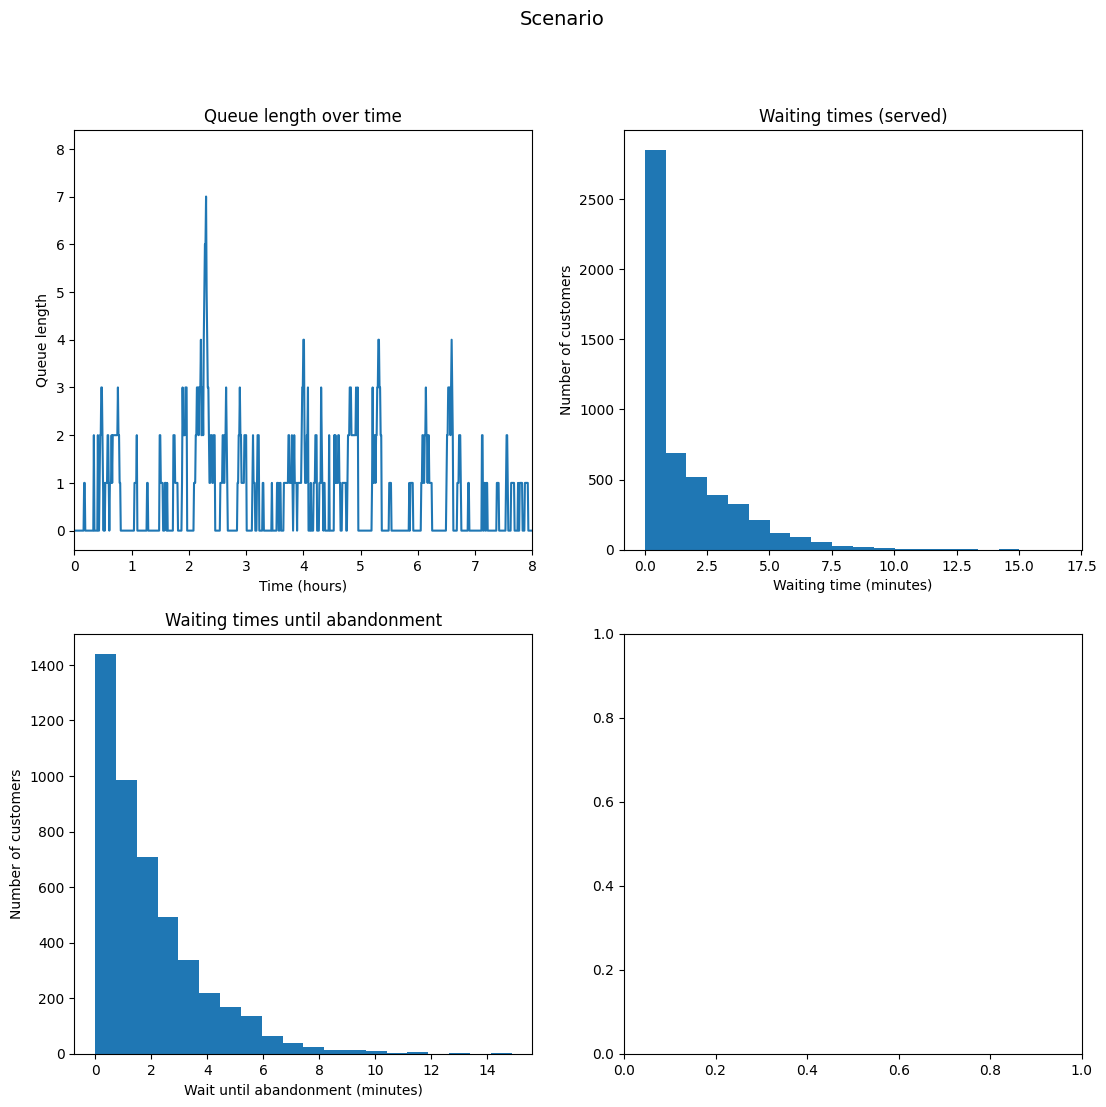

In [124]:
simulation_a = run_simulation()
plot_results(simulation_a)


=== Simulation results (M/M/1 with abandonment depends on Queue Length, fixed customers) ===
λ (arrival rate):      30.00 / hour
μ (service rate):      20.00 / hour
Total arrivals target:  10000
Total arrivals (done):  10000
Served:                 5503
Abandoned:              4497
Average queue length:   1.033
Abandonment fraction:   0.450
Avg wait (served):      0.033 hours
Avg wait (abandoned):   0.036 hours


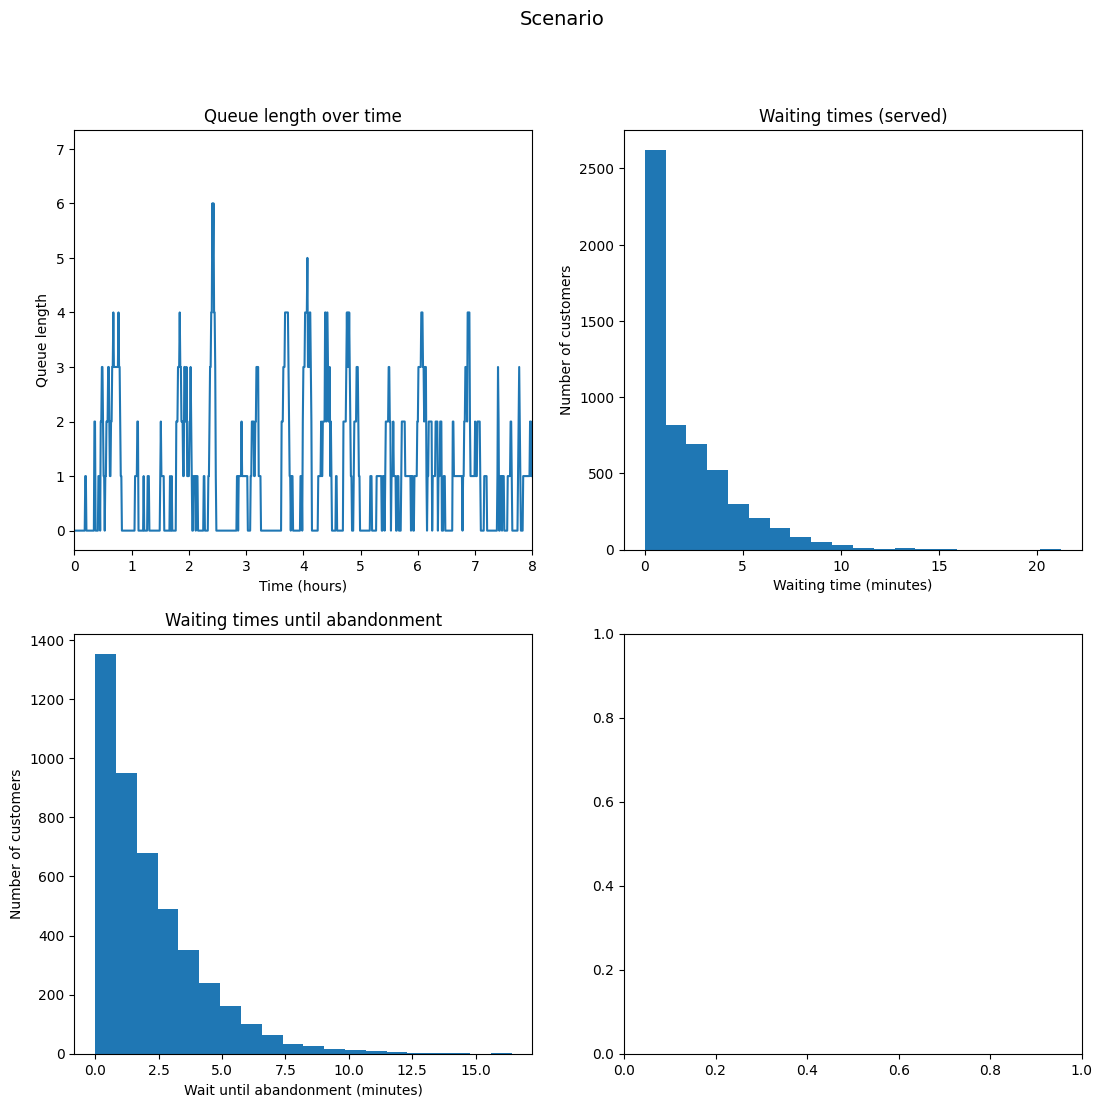

In [125]:
simulation_b = run_simulation2()
plot_results(simulation_b)


=== Simulation results (M/M/1 with abandonment depends on heuristic customer threshold, fixed customers) ===
λ (arrival rate):     30.00 / hour
μ (service rate):      20.00 / hour
Total arrivals:        10000
Served:                6131
Abandoned:             3869
Average queue length: 2.271
Avg queue length arrival:2.26
Abandonment fraction:  0.387
Avg wait (served):     0.058 hours
Avg wait (abandoned):  0.106 hours


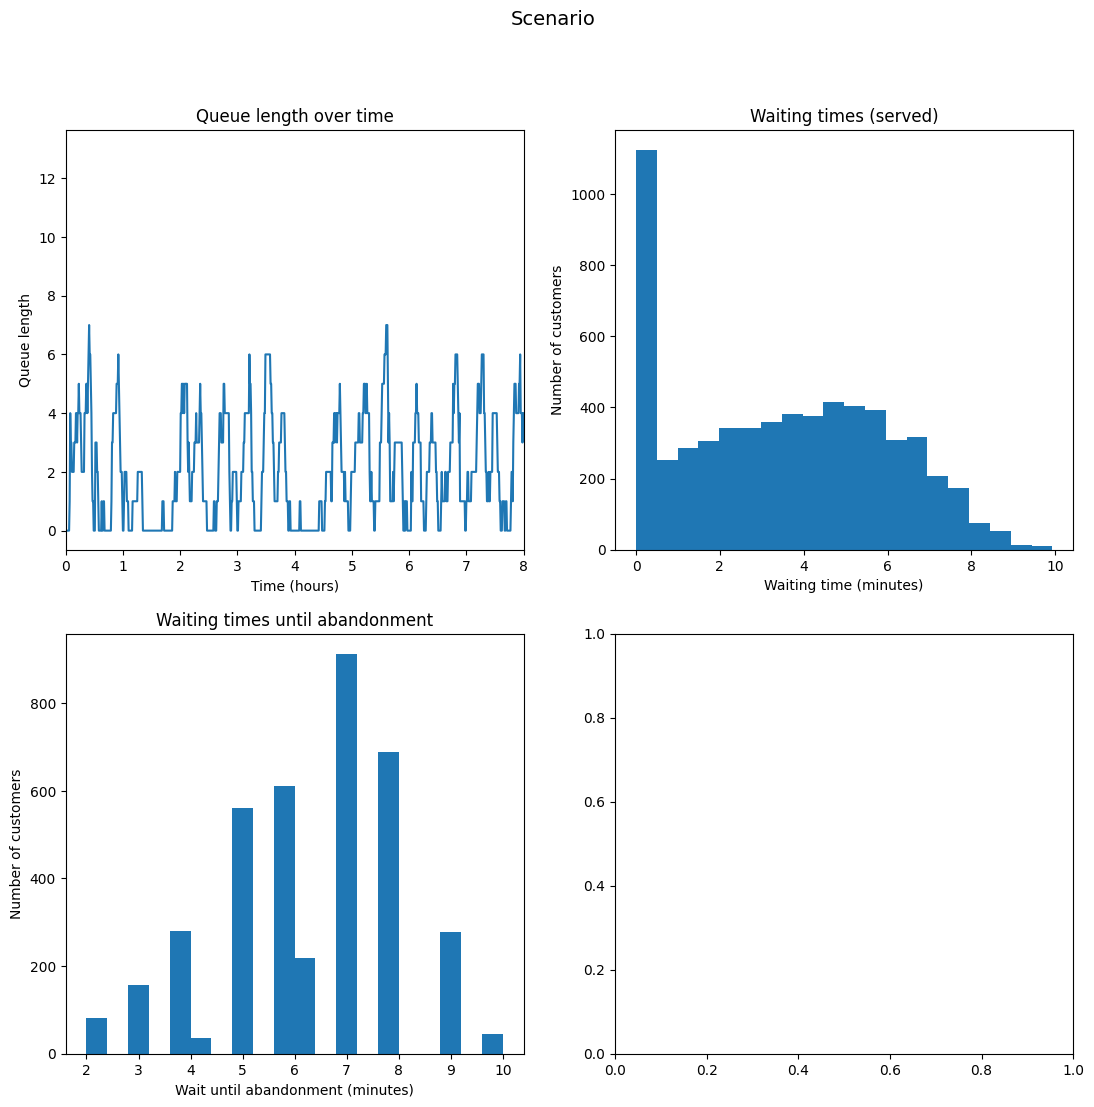

In [126]:
simulation_c = run_simulation3()
plot_results(simulation_c)